# Data Transformation and feature evaluation for set 3

In [32]:
from pathlib import Path
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from knee_stress_predict.config import raw_data_dir, processed_data_dir

This notebook prepare data for training time serial model.

## Step 1: Load data

In [33]:
data_set_name = "set_3"
file_path = Path.joinpath(processed_data_dir, data_set_name,  "out.csv")
result = pd.read_csv(file_path)
result = result.drop('Unnamed: 0', axis=1)
result.reset_index()

,index,Code,Patella_PN,Femur_PN,Tibia_PN,Patella_Car_PN,Femur_Car_PN,Tibia_M_Car_PN,Tibia_L_Car_PN,Patella_volume,...,med_frame_231,med_frame_232,med_frame_233,med_frame_234,med_frame_235,med_frame_236,med_frame_237,med_frame_238,med_frame_239,med_frame_240
0,0,9003406M00,1137,4142,2789,5275,21420,2840,2840,33682.157434,...,9.759382,9.932714,9.782494,9.542757,9.550017,9.888674,10.287620,10.229705,10.525443,10.990571
1,1,9003406M12,1126,4113,2684,5900,21030,2840,2840,33039.218053,...,9.806394,9.903366,9.658813,9.345903,8.863383,8.515292,8.726943,8.729221,8.886322,9.224288
2,2,9007827M00,771,3414,2596,4485,18385,2840,2840,21736.919532,...,6.839143,6.736033,6.599309,6.549271,6.820798,6.718779,6.745682,6.785289,6.868892,7.046464
3,3,9007827M12,730,3404,2600,5055,18755,2840,2840,20866.993760,...,6.069279,6.093854,6.118194,6.276575,6.574237,6.211847,6.384310,6.605030,6.585426,6.867692
4,4,9040390M00,670,3907,2560,4935,19150,2840,2840,17988.202111,...,122.803833,122.954926,123.055641,123.183105,123.373184,123.773911,123.798569,123.820938,123.799873,123.741707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,164,9993650M12,686,2963,2388,4405,20910,2155,2840,15821.015946,...,30.319807,31.751848,33.184460,34.442417,30.123833,15.865294,15.989101,16.239870,16.647863,17.259405
165,165,9993833M00,795,3669,2724,4765,20410,2840,2840,22375.020348,...,8.792763,8.976914,8.909942,10.684889,11.045062,10.653504,9.277707,9.529099,9.912118,10.419240
166,166,9993833M12,801,3805,2575,4885,20400,2840,2840,22439.863013,...,8.802687,9.059080,9.370121,10.105094,9.852423,9.866968,9.584963,9.702561,9.904342,10.722541
167,167,9993846M00,868,3794,3029,5430,20755,2840,2840,25084.417057,...,7.280858,7.429334,7.494839,7.629389,7.617738,7.752455,8.115380,7.971771,8.071439,8.470410


## Step 2: Split data

- traing 80%
- test 20%

In [50]:
rng = np.random.RandomState(20221029)

test_dataset = result.sample(frac=0.20, random_state=rng)
train_mask = pd.Series(True, index=result.index)
train_mask[test_dataset.index] = False
train_dataset = result[train_mask].copy()
train_dataset.head()

,Code,Patella_PN,Femur_PN,Tibia_PN,Patella_Car_PN,Femur_Car_PN,Tibia_M_Car_PN,Tibia_L_Car_PN,Patella_volume,Femur_volume,...,med_frame_231,med_frame_232,med_frame_233,med_frame_234,med_frame_235,med_frame_236,med_frame_237,med_frame_238,med_frame_239,med_frame_240
0,9003406M00,1137,4142,2789,5275,21420,2840,2840,33682.157434,231437.991665,...,9.759382,9.932714,9.782494,9.542757,9.550017,9.888674,10.287620,10.229705,10.525443,10.990571
1,9003406M12,1126,4113,2684,5900,21030,2840,2840,33039.218053,228671.171460,...,9.806394,9.903366,9.658813,9.345903,8.863383,8.515292,8.726943,8.729221,8.886322,9.224288
2,9007827M00,771,3414,2596,4485,18385,2840,2840,21736.919532,184294.924991,...,6.839143,6.736033,6.599309,6.549271,6.820798,6.718779,6.745682,6.785289,6.868892,7.046464
3,9007827M12,730,3404,2600,5055,18755,2840,2840,20866.993760,184114.045604,...,6.069279,6.093854,6.118194,6.276575,6.574237,6.211847,6.384310,6.605030,6.585426,6.867692
4,9040390M00,670,3907,2560,4935,19150,2840,2840,17988.202111,226082.515840,...,122.803833,122.954926,123.055641,123.183105,123.373184,123.773911,123.798569,123.820938,123.799873,123.741707


## Step 3: Transform data

Now let's create a tall table, so we can extract data in a specific tall format, which is more useful for training models.

In [51]:
def transform_to_tall(data):
    column_names = list(data.columns)
    column_names = [item for item in column_names if 'med_frame' not in item]
    column_names = [item for item in column_names if 'lat_frame' not in item]

    data = pd.wide_to_long(data,
                        stubnames=["med_frame_", "lat_frame_"],
                        i=column_names,
                        j="frame")
    data = data.rename(columns={"med_frame_": "Max_tib_med_contact_pressure", "lat_frame_": "Max_tib_lat_contact_pressure"})
    data = data.reset_index()

    return data

def remove_outliers(data):
    result_no_outliers = data[data['Max_tib_lat_contact_pressure'] < 200]
    result_no_outliers = result_no_outliers[result_no_outliers['Max_tib_med_contact_pressure'] < 200]

    return result_no_outliers


In [52]:
test_dataset = transform_to_tall(test_dataset)
train_dataset = transform_to_tall(train_dataset)

### Remove outliers:

#### Check distribution of maximal contact pressure

(array([2.8868e+04, 5.7900e+02, 3.3700e+02, 2.3100e+02, 2.0500e+02,
        1.0800e+02, 6.2000e+01, 1.9000e+01, 8.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00,
        1.0000e+00, 2.0000e+00, 2.0000e+00, 2.0000e+00, 3.0000e+00,
        2.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([   3.90188527,   39.50438265,   75.10688003,  110.70937741,
         146.31187479,  181.91437217,  217.51686954,  253.11936692,
         288.7218643 ,  324.32436168,  359.92685906,  395.52935644,
         431.13185382,  466.7343512 ,  502.33684858,  537.93934596,
         573.54184333,  609.14434071,  644.74683809,  680.34933547,
         715.95183285,  751.55433023,  787.15682761,  822.75932499,
         858.36182237,  893.96431975,  929.56681712,  965.1693145 ,
        1000.77181188, 1036.37430926, 1071.97680664]),
 <BarContainer object of 30 artists>)

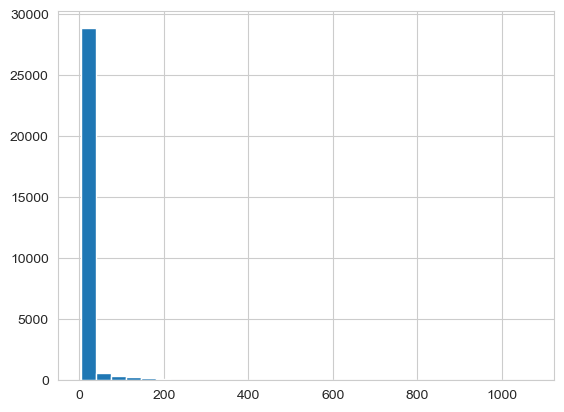

In [53]:
plt.hist(train_dataset['Max_tib_med_contact_pressure'], bins = 30)

(array([7.4010e+03, 2.0295e+04, 2.2840e+03, 1.6600e+02, 8.0000e+01,
        4.5000e+01, 4.9000e+01, 5.0000e+00, 1.3000e+01, 8.0000e+00,
        7.0000e+00, 8.0000e+00, 6.0000e+00, 6.0000e+00, 1.1000e+01,
        5.0000e+00, 6.0000e+00, 4.0000e+00, 1.3000e+01, 6.0000e+00,
        3.0000e+00, 2.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00,
        2.0000e+00, 5.0000e+00, 3.0000e+00, 4.0000e+00, 6.0000e+00]),
 array([  0.        ,  11.19371033,  22.38742065,  33.58113098,
         44.77484131,  55.96855164,  67.16226196,  78.35597229,
         89.54968262, 100.74339294, 111.93710327, 123.1308136 ,
        134.32452393, 145.51823425, 156.71194458, 167.90565491,
        179.09936523, 190.29307556, 201.48678589, 212.68049622,
        223.87420654, 235.06791687, 246.2616272 , 257.45533752,
        268.64904785, 279.84275818, 291.03646851, 302.23017883,
        313.42388916, 324.61759949, 335.81130981]),
 <BarContainer object of 30 artists>)

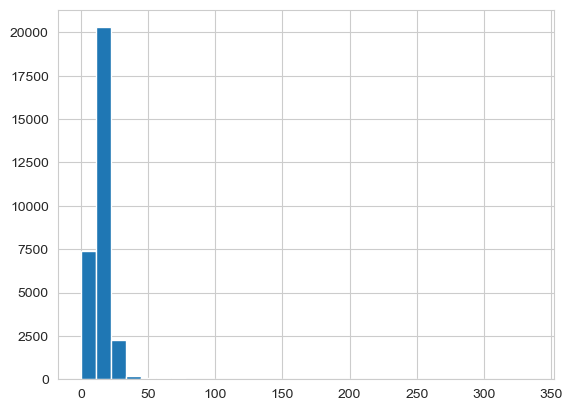

In [54]:
plt.hist(train_dataset['Max_tib_lat_contact_pressure'], bins = 30)

Contact pressure for both medial and lateral cartilages is distributed very unequally. There are outliers with unusually high contact pressure. Let’s remove outliers, knee with high maximal tibia cartilage contact pressure (>200). Since we have data for all 240-time points, we do not need to remove the whole simulation but just corrupted frames.

In [55]:
test_dataset = remove_outliers(test_dataset)
train_dataset = remove_outliers(train_dataset)

In [56]:
train_dataset

,Code,Patella_PN,Femur_PN,Tibia_PN,Patella_Car_PN,Femur_Car_PN,Tibia_M_Car_PN,Tibia_L_Car_PN,Patella_volume,Femur_volume,...,Simulation_len,Max_dist_femur_tibia_lat_car,Min_dist_femur_tibia_lat_car,Mean_dist_femur_tibia_lat_car,Max_dist_femur_tibia_med_car,Min_dist_femur_tibia_med_car,Mean_dist_femur_tibia_med_car,frame,Max_tib_med_contact_pressure,Max_tib_lat_contact_pressure
0,9003406M00,1137,4142,2789,5275,21420,2840,2840,33682.157434,231437.991665,...,0,13.941570,0.987391,6.105886,10.304892,1.376902,4.580906,0,7.619495,6.696390
1,9003406M00,1137,4142,2789,5275,21420,2840,2840,33682.157434,231437.991665,...,0,13.941570,0.987391,6.105886,10.304892,1.376902,4.580906,1,8.068417,5.042103
2,9003406M00,1137,4142,2789,5275,21420,2840,2840,33682.157434,231437.991665,...,0,13.941570,0.987391,6.105886,10.304892,1.376902,4.580906,2,7.796326,5.344840
3,9003406M00,1137,4142,2789,5275,21420,2840,2840,33682.157434,231437.991665,...,0,13.941570,0.987391,6.105886,10.304892,1.376902,4.580906,3,8.058777,6.240049
4,9003406M00,1137,4142,2789,5275,21420,2840,2840,33682.157434,231437.991665,...,0,13.941570,0.987391,6.105886,10.304892,1.376902,4.580906,4,8.098284,7.306662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32530,9993846M12,873,3921,2831,5690,21495,2840,2840,24799.135262,226161.340527,...,12,18.862473,2.616759,6.815766,15.943200,2.833736,6.482209,236,11.455851,7.974414
32531,9993846M12,873,3921,2831,5690,21495,2840,2840,24799.135262,226161.340527,...,12,18.862473,2.616759,6.815766,15.943200,2.833736,6.482209,237,11.642740,8.043670
32532,9993846M12,873,3921,2831,5690,21495,2840,2840,24799.135262,226161.340527,...,12,18.862473,2.616759,6.815766,15.943200,2.833736,6.482209,238,12.039758,8.359842
32533,9993846M12,873,3921,2831,5690,21495,2840,2840,24799.135262,226161.340527,...,12,18.862473,2.616759,6.815766,15.943200,2.833736,6.482209,239,11.383085,8.170403


## Correlation matrix

###  All 240 frames

Text(0.5, 1.0, 'No outliers Correlation Heatmap for all frames')

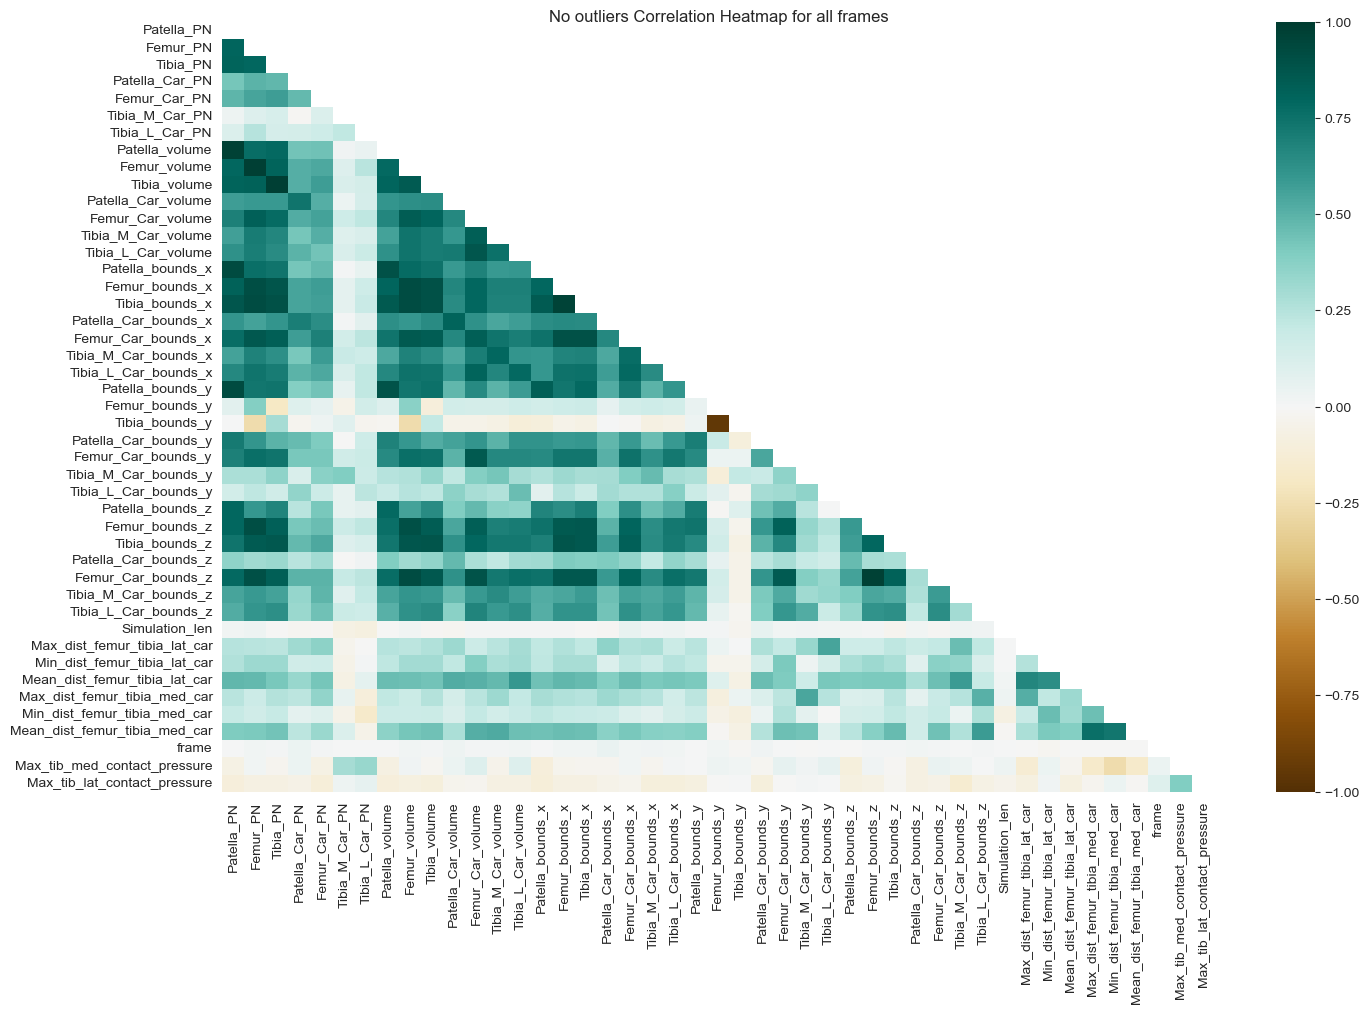

In [57]:
plt.figure(figsize=(16, 10))
mask = np.triu(np.ones_like(train_dataset.corr(), dtype=np.bool))
heatmap = sns.heatmap(train_dataset.corr(), mask=mask, vmin=-1, vmax=1, annot=False, cmap='BrBG')
heatmap.set_title('No outliers Correlation Heatmap for all frames', fontdict={'fontsize':12}, pad=0)

### Specific frame

Text(0.5, 1.0, 'No outliers Correlation Heatmap for # 240 time frame')

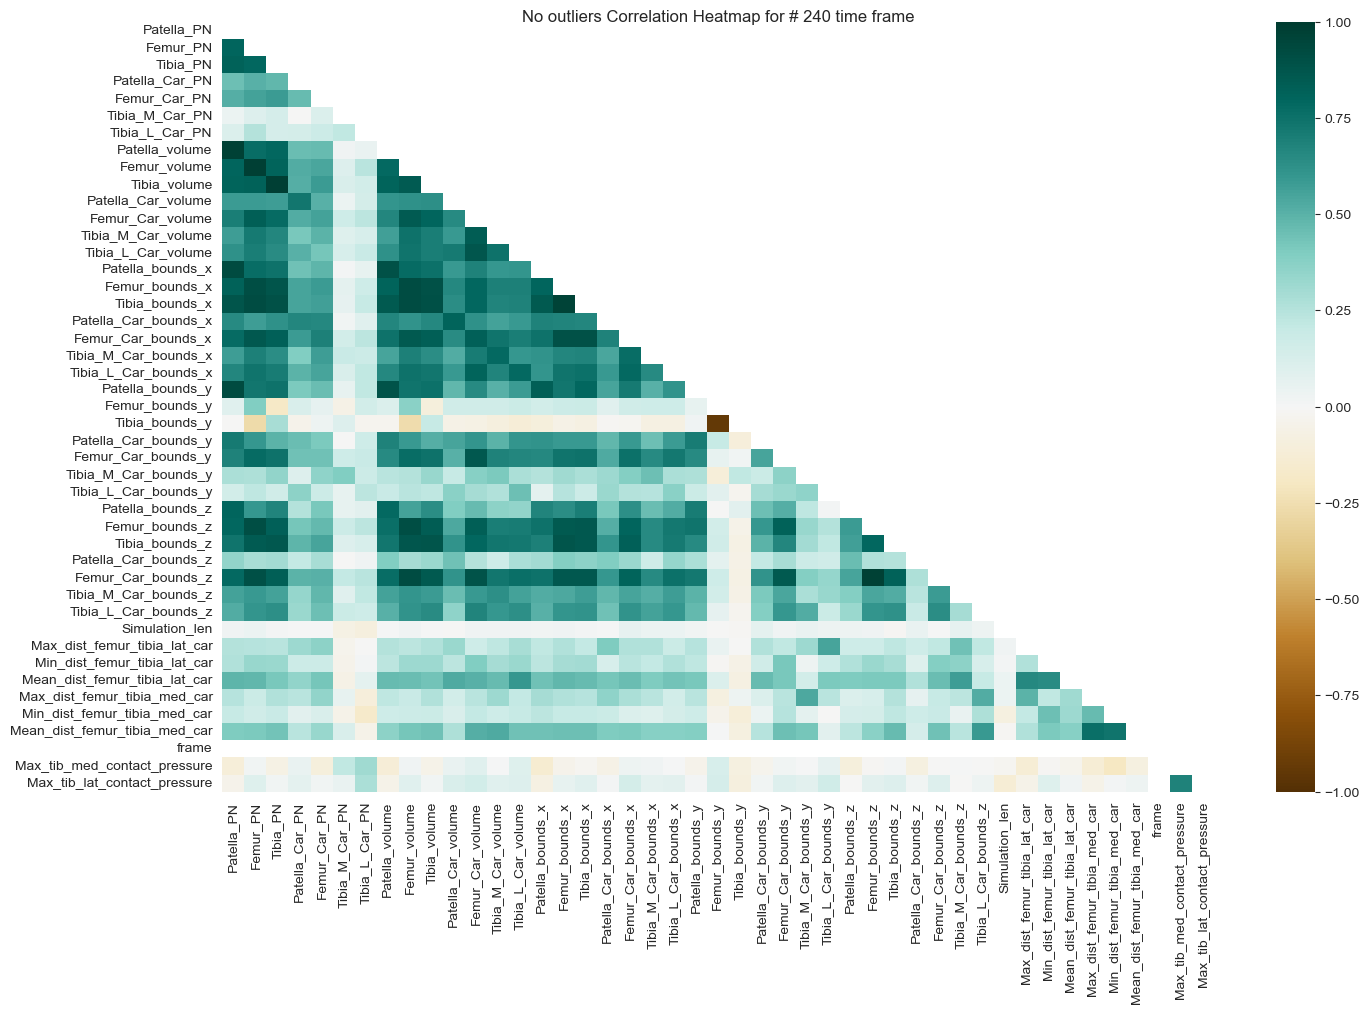

In [58]:
time_frame_num = 240
result_no_outliers_frame = train_dataset[train_dataset['frame'] == time_frame_num]
plt.figure(figsize=(16, 10))
mask = np.triu(np.ones_like(train_dataset.corr(), dtype=np.bool))
heatmap = sns.heatmap(result_no_outliers_frame.corr(), mask=mask, vmin=-1, vmax=1, annot=False, cmap='BrBG')
heatmap.set_title(f'No outliers Correlation Heatmap for # {time_frame_num} time frame', fontdict={'fontsize':12}, pad=0)

In [59]:
result_no_outliers_frame

,Code,Patella_PN,Femur_PN,Tibia_PN,Patella_Car_PN,Femur_Car_PN,Tibia_M_Car_PN,Tibia_L_Car_PN,Patella_volume,Femur_volume,...,Simulation_len,Max_dist_femur_tibia_lat_car,Min_dist_femur_tibia_lat_car,Mean_dist_femur_tibia_lat_car,Max_dist_femur_tibia_med_car,Min_dist_femur_tibia_med_car,Mean_dist_femur_tibia_med_car,frame,Max_tib_med_contact_pressure,Max_tib_lat_contact_pressure
240,9003406M00,1137,4142,2789,5275,21420,2840,2840,33682.157434,231437.991665,...,0,13.941570,0.987391,6.105886,10.304892,1.376902,4.580906,240,10.990571,7.570806
481,9003406M12,1126,4113,2684,5900,21030,2840,2840,33039.218053,228671.171460,...,12,13.560157,0.800195,6.226970,10.677269,1.029139,4.306716,240,9.224288,9.649994
722,9007827M00,771,3414,2596,4485,18385,2840,2840,21736.919532,184294.924991,...,0,12.892850,1.504442,4.844820,9.243396,1.418712,4.015682,240,7.046464,8.911654
963,9007827M12,730,3404,2600,5055,18755,2840,2840,20866.993760,184114.045604,...,12,11.617199,1.119438,4.698536,9.107268,1.398252,3.890993,240,6.867692,7.769055
1204,9040390M00,670,3907,2560,4935,19150,2840,2840,17988.202111,226082.515840,...,0,14.107578,2.342441,6.161425,10.770141,2.071546,5.517447,240,123.741707,165.708923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31570,9993650M00,633,3084,2205,4255,20260,2185,2840,15168.028148,146698.667898,...,0,14.732158,1.686715,5.659945,13.039994,1.308433,4.848711,240,16.606964,13.847254
31811,9993833M00,795,3669,2724,4765,20410,2840,2840,22375.020348,207318.185631,...,0,16.633343,1.874496,6.641354,15.426130,2.258161,4.898385,240,10.419240,10.214434
32052,9993833M12,801,3805,2575,4885,20400,2840,2840,22439.863013,215968.865103,...,12,17.640301,1.481010,6.875417,12.561378,2.246910,4.471387,240,10.722541,7.027453
32293,9993846M00,868,3794,3029,5430,20755,2840,2840,25084.417057,216622.182978,...,0,19.743281,2.204936,6.574413,16.267729,1.759706,5.525146,240,8.470410,8.585914


### Transform categorical features to dummy

Transform "Simulation_len" to dummy variable. We have only two options for that variable 0 and 12


In [60]:
train_dataset['Simulation_len'] = pd.get_dummies(train_dataset['Simulation_len'], drop_first=True)
train_dataset.rename(columns={"Simulation_len": "12_month_sim"})


test_dataset['Simulation_len'] = pd.get_dummies(test_dataset['Simulation_len'], drop_first=True)
test_dataset.rename(columns={"Simulation_len": "12_month_sim"})

,Code,Patella_PN,Femur_PN,Tibia_PN,Patella_Car_PN,Femur_Car_PN,Tibia_M_Car_PN,Tibia_L_Car_PN,Patella_volume,Femur_volume,...,12_month_sim,Max_dist_femur_tibia_lat_car,Min_dist_femur_tibia_lat_car,Mean_dist_femur_tibia_lat_car,Max_dist_femur_tibia_med_car,Min_dist_femur_tibia_med_car,Mean_dist_femur_tibia_med_car,frame,Max_tib_med_contact_pressure,Max_tib_lat_contact_pressure
0,9912946M00,788,4137,2689,5575,21035,2840,2840,22692.085291,248976.459037,...,0,13.779237,1.205597,4.272830,20.666032,2.178122,6.670601,0,5.602037,8.015358
1,9912946M00,788,4137,2689,5575,21035,2840,2840,22692.085291,248976.459037,...,0,13.779237,1.205597,4.272830,20.666032,2.178122,6.670601,1,5.168147,7.968657
2,9912946M00,788,4137,2689,5575,21035,2840,2840,22692.085291,248976.459037,...,0,13.779237,1.205597,4.272830,20.666032,2.178122,6.670601,2,4.959132,8.210285
3,9912946M00,788,4137,2689,5575,21035,2840,2840,22692.085291,248976.459037,...,0,13.779237,1.205597,4.272830,20.666032,2.178122,6.670601,3,4.689206,8.656764
4,9912946M00,788,4137,2689,5575,21035,2840,2840,22692.085291,248976.459037,...,0,13.779237,1.205597,4.272830,20.666032,2.178122,6.670601,4,5.043017,9.217077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8189,9596610M00,495,2775,1924,4585,18055,2750,2840,11866.160605,136108.014091,...,0,16.067871,1.079834,5.494725,11.147517,0.039799,3.149434,236,11.860928,14.329642
8190,9596610M00,495,2775,1924,4585,18055,2750,2840,11866.160605,136108.014091,...,0,16.067871,1.079834,5.494725,11.147517,0.039799,3.149434,237,11.318072,12.649292
8191,9596610M00,495,2775,1924,4585,18055,2750,2840,11866.160605,136108.014091,...,0,16.067871,1.079834,5.494725,11.147517,0.039799,3.149434,238,11.081848,13.235381
8192,9596610M00,495,2775,1924,4585,18055,2750,2840,11866.160605,136108.014091,...,0,16.067871,1.079834,5.494725,11.147517,0.039799,3.149434,239,11.016224,17.159264


In [61]:
train_dataset

,Code,Patella_PN,Femur_PN,Tibia_PN,Patella_Car_PN,Femur_Car_PN,Tibia_M_Car_PN,Tibia_L_Car_PN,Patella_volume,Femur_volume,...,Simulation_len,Max_dist_femur_tibia_lat_car,Min_dist_femur_tibia_lat_car,Mean_dist_femur_tibia_lat_car,Max_dist_femur_tibia_med_car,Min_dist_femur_tibia_med_car,Mean_dist_femur_tibia_med_car,frame,Max_tib_med_contact_pressure,Max_tib_lat_contact_pressure
0,9003406M00,1137,4142,2789,5275,21420,2840,2840,33682.157434,231437.991665,...,0,13.941570,0.987391,6.105886,10.304892,1.376902,4.580906,0,7.619495,6.696390
1,9003406M00,1137,4142,2789,5275,21420,2840,2840,33682.157434,231437.991665,...,0,13.941570,0.987391,6.105886,10.304892,1.376902,4.580906,1,8.068417,5.042103
2,9003406M00,1137,4142,2789,5275,21420,2840,2840,33682.157434,231437.991665,...,0,13.941570,0.987391,6.105886,10.304892,1.376902,4.580906,2,7.796326,5.344840
3,9003406M00,1137,4142,2789,5275,21420,2840,2840,33682.157434,231437.991665,...,0,13.941570,0.987391,6.105886,10.304892,1.376902,4.580906,3,8.058777,6.240049
4,9003406M00,1137,4142,2789,5275,21420,2840,2840,33682.157434,231437.991665,...,0,13.941570,0.987391,6.105886,10.304892,1.376902,4.580906,4,8.098284,7.306662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32530,9993846M12,873,3921,2831,5690,21495,2840,2840,24799.135262,226161.340527,...,1,18.862473,2.616759,6.815766,15.943200,2.833736,6.482209,236,11.455851,7.974414
32531,9993846M12,873,3921,2831,5690,21495,2840,2840,24799.135262,226161.340527,...,1,18.862473,2.616759,6.815766,15.943200,2.833736,6.482209,237,11.642740,8.043670
32532,9993846M12,873,3921,2831,5690,21495,2840,2840,24799.135262,226161.340527,...,1,18.862473,2.616759,6.815766,15.943200,2.833736,6.482209,238,12.039758,8.359842
32533,9993846M12,873,3921,2831,5690,21495,2840,2840,24799.135262,226161.340527,...,1,18.862473,2.616759,6.815766,15.943200,2.833736,6.482209,239,11.383085,8.170403


## Save data

In [62]:
train_output_path = Path.joinpath(processed_data_dir, data_set_name, "train_cleaned.csv")
train_dataset.to_csv(train_output_path)

test_output_path = Path.joinpath(processed_data_dir, data_set_name, "test_cleaned.csv")
test_dataset.to_csv(test_output_path)